<a href="https://colab.research.google.com/github/honghusldl/capstone-project-city-segmentation/blob/main/the_battle_of_neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

### Table of contents
* Introduction
* Data description
* Methodology and results (Code and explainations)
* Discussion and conclusion
* Future expectation

## Introduction:

The aim of this project is to find the best neighborhood in Toronto to open a new Chinese restaurant. In this project, we will utilize FourSquare API to retrieve location data and also explore venues in Toronto. We will analyze the neighborhoods by two types of clustering. Type I is clustering neighborhoods by speicific one venue category, Chinese restaurant, whereas Type II is clustering neighborhoods by all venue cateogories. Considering business people may make their decisions from different angle, I provide two means here. Type I clustering (Chinese restaurant only) focuses on competitive strength from Chinese restaurant specifically, while Type II clustering (all venues) emphasizes competition between all businesses.

## Data Description:

1: Basic Toronto data including Toronto's borough, neighborhoods, postal codes data from Wikipedia. Data sources: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

2: Geospatial data for Toronto's postal codes. Data sources:https://cocl.us/Geospatial_data. Data is retrieved by **Geocoder package**.

3: Toronto's venues data including venue name, venue geospatial information (latitude and longitude) and venue categories. Data is retrieved by **FourSquare API** with personal credentials.

## Import Libararies

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns
import folium
import requests
from pandas.io.json import json_normalize

from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

##Methodology and Results （Code and Explainations)

## Part 1: Webscraping

Extract information about postal code of different neighborhoods from wiki page (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

In [2]:
# define soup oject to further extract information from the table in the web page
toronto_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html_data = requests.get(toronto_url).text
toronto_soup = BeautifulSoup(html_data)

Extract postalcode, borough and neighborhood from the table in the page

Create a list containing dictinoary with 3 keys

In [3]:
# extract postalcode, borough and neighborhood from the table in the page
# create a list containing dictinoary with 3 keys
toronto_info = []
table = toronto_soup.find('table')
for row in table.findAll('td'):
  cell={}
  if row.span.text=='Not assigned':
    pass
  else:
    cell['PostalCode']=row.p.text[:3]
    cell['Borough']=(row.span.text).split('(')[0]
    cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
    toronto_info.append(cell)

print(toronto_info)

[{'PostalCode': 'M3A', 'Borough': 'North York', 'Neighborhood': 'Parkwoods'}, {'PostalCode': 'M4A', 'Borough': 'North York', 'Neighborhood': 'Victoria Village'}, {'PostalCode': 'M5A', 'Borough': 'Downtown Toronto', 'Neighborhood': 'Regent Park, Harbourfront'}, {'PostalCode': 'M6A', 'Borough': 'North York', 'Neighborhood': 'Lawrence Manor, Lawrence Heights'}, {'PostalCode': 'M7A', 'Borough': "Queen's Park", 'Neighborhood': 'Ontario Provincial Government'}, {'PostalCode': 'M9A', 'Borough': 'Etobicoke', 'Neighborhood': 'Islington Avenue'}, {'PostalCode': 'M1B', 'Borough': 'Scarborough', 'Neighborhood': 'Malvern, Rouge'}, {'PostalCode': 'M3B', 'Borough': 'North York', 'Neighborhood': 'Don Mills North'}, {'PostalCode': 'M4B', 'Borough': 'East York', 'Neighborhood': 'Parkview Hill, Woodbine Gardens'}, {'PostalCode': 'M5B', 'Borough': 'Downtown Toronto', 'Neighborhood': 'Garden District, Ryerson'}, {'PostalCode': 'M6B', 'Borough': 'North York', 'Neighborhood': 'Glencairn'}, {'PostalCode': 'M9

In [4]:
# create a dataframe containing all neighborhood information
df = pd.DataFrame(toronto_info)

# replace names in borough
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [5]:
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [6]:
df.Neighborhood.value_counts()

Wexford, Maryvale                                                                                                                         1
Kensington Market, Chinatown, Grange Park                                                                                                 1
Bedford Park, Lawrence Manor East                                                                                                         1
Fairview, Henry Farm, Oriole                                                                                                              1
Runnymede, Swansea                                                                                                                        1
Downsview West                                                                                                                            1
Willowdale, Newtonbrook                                                                                                                   1
Caledonia-Fairbanks 

## Part2: Retrieving geospatial data for neighborhoods in Toronto

Create an another dataframe containing geospatial information

In [7]:
df_coord = pd.read_csv('https://cocl.us/Geospatial_data')
df_coord.columns=['PostalCode','Latitude','Longitude']
df_coord.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

Merge two dataframe based on the same postal code into a comprehensive dataframe

In [8]:
df_toronto = pd.merge(df,df_coord,on='PostalCode')
df_toronto.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

## Part3: Data exploration on neighborhoods and venues in Toronto

## Further explore neighhoods in Toronto.

1: Find out the geographical coordinates of Toronto.

In [9]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


2: Visualize neighborhoods in Toronto.

In [10]:
map_toronto = folium.Map(location=[latitude,longitude], zoom_start=12)

# add markers for neighborhoods
for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(map_toronto)  

map_toronto

3: Define FourSquare credentials and version

In [11]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version
# personal info removed after the project was completed

In [12]:
LIMIT = 100
radius = 500

4: Retrieve venues' information in Toronto

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],latitudes=df_toronto['Latitude'],longitudes=df_toronto['Longitude'])
toronto_venues.head()

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods              43.753259              -79.329656   
1         Parkwoods              43.753259              -79.329656   
2         Parkwoods              43.753259              -79.329656   
3  Victoria Village              43.725882              -79.315572   
4  Victoria Village              43.725882              -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1                     KFC       43.754387       -79.333021   
2           Variety Store       43.751974       -79.333114   
3  Victoria Village Arena       43.723481       -79.315635   
4             Tim Hortons       43.725517       -79.313103   

         Venue Category  
0                  Park  
1  Fast Food Restaurant  
2     Food & Drink Shop  
3          Hockey Arena  
4           Coffee Shop

In [15]:
toronto_venues.shape

(2128, 7)

5: We can observe that there are 268 unique venue categories in neighborhoods in Toronto.

In [16]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               5   
Alderwood, Long Branch                                                  7   
Bathurst Manor, Wilson Heights, Downsview North                        23   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      26   
Berczy Park                                                            55   
Birch Cliff, Cliffside West                                             5   
Brockton, Parkdale Village, Exhibition Place                           24   
CN Tower, King and Spadina, Railway Lands, Harb...                     15   
Caledonia-Fairbanks                                                     4   
Cedarbrae                                                               9   
Central Bay Street                                                     66   
Christie                                                               16   
Church and Wellesley                                                   80   
Clairville, Humberwood, Woodbine Downs, West Hu...                      5   
Clarks Corners, Tam O'Shanter, Sullivan                                12   
Cliffside, Cliffcrest, Scarborough Village West                         2   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             36   
Davisville North                                                        9   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        4   
Don Mills North                                                         5   
Don Mills South                                                        20   
Dorset Park, Wexford Heights, Scarborough Town ...                      5   
Downsview Central                                                       3   
Downsview East                                                          2   
Downsview Northwest                                                     4   
Downsview West                                                          4   
Dufferin, Dovercourt Village                                           14   
Enclave of L4W                                                         14   
Enclave of M4L                                                         17   
Enclave of M5E                                                         96   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      9   
Fairview, Henry Farm, Oriole                                           65   
First Canadian Place, Underground city                                100   
Forest Hill North & West                                                4   
Garden District, Ryerson                                              100   
Glencairn                                                               4   
Golden Mile, Clairlea, Oakridge                                         7   
Guildwood, Morningside, West Hill                                       8   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          26   
Hillcrest Village                                                       5   
Humber Summit                                                           1   
Humberlea, Emery                                                        1   
Humewood-Cedarvale                                                      3   
India Bazaar, The Beaches West                                         20   
Kennedy Park, Ionview, East Birchmount Park                             6   
Kensington Market, Chinatown, Grange Park                              67   
Kingsview Village, St. Phillips, Martin Grove G...                      4   
Lawrence Manor, Lawrence Heights                

In [17]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 276 uniques categories.


There are 274 unique venue categories in Toronto, however, for the purpose of this project, we will focus on Chinese Restaurant.

6: Analyze venues in each Toronto's neighborhood.

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

Yoga Studio  Accessories Store  Adult Boutique  Airport  \
0            0                  0               0        0   
1            0                  0               0        0   
2            0                  0               0        0   
3            0                  0               0        0   
4            0                  0               0        0   

   Airport Food Court  Airport Lounge  Airport Service  Airport Terminal  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   

   American Restaurant  Antique Shop  Aquarium  Art Gallery  Art Museum  \
0                    0             0         0            0           0   
1                    0             0         0            0           0   
2                    0             0         0            0           0   
3                    0             0         0            0           0   
4                    0             0         0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                    0                 0                   0            0   
1                    0                 0                   0            0   
2                    0                 0                   0            0   
3                    0                 0                   0            0   
4                    0                 0                   0            0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0              0          0           0           0       0     0    0   
1              0          0           0           0       0     0    0   
2              0          0           0           0       0     0    0   
3              0          0           0           0       0     0    0   
4              0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
0      0                0         0           0                   0   
1      0                0         0           0                   0   
2      0                0         0           0                   0   
3      0                0         0           0                   0   
4      0                0         0           0                   0   

   Bike Shop  Bistro  Boat or Ferry  Bookstore  Boutique  \
0          0       0              0          0         0   
1          0       0              0          0         0   
2          0       0              0          0         0   
3          0       0              0          0         0   
4          0       0              0          0         0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                     0               0        0            0   
1                     0               0        0            0   
2                     0               0        0            0   
3                     0               0        0            0   
4                     0               0        0            0   

   Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0                0         0             0              0         0   
1                0         0  

In [19]:
toronto_onehot.shape

(2128, 276)

7: Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [20]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(100, 276)


Neighborhood  Yoga Studio  \
0                                        Agincourt          0.0   
1                           Alderwood, Long Branch          0.0   
2  Bathurst Manor, Wilson Heights, Downsview North          0.0   
3                                  Bayview Village          0.0   
4                Bedford Park, Lawrence Manor East          0.0   

   Accessories Store  Adult Boutique  Airport  Airport Food Court  \
0                0.0             0.0      0.0                 0.0   
1                0.0             0.0      0.0                 0.0   
2                0.0             0.0      0.0                 0.0   
3                0.0             0.0      0.0                 0.0   
4                0.0             0.0      0.0                 0.0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0             0.0              0.0               0.0             0.000000   
1             0.0              0.0               0.0             0.000000   
2             0.0              0.0               0.0             0.000000   
3             0.0              0.0               0.0             0.000000   
4             0.0              0.0               0.0             0.038462   

   Antique Shop  Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  \
0           0.0       0.0          0.0         0.0                  0.0   
1           0.0       0.0          0.0         0.0                  0.0   
2           0.0       0.0          0.0         0.0                  0.0   
3           0.0       0.0          0.0         0.0                  0.0   
4           0.0       0.0          0.0         0.0                  0.0   

   Asian Restaurant  Athletics & Sports  Auto Garage  Auto Workshop  \
0               0.0                 0.0          0.0            0.0   
1               0.0                 0.0          0.0            0.0   
2               0.0                 0.0          0.0            0.0   
3               0.0                 0.0          0.0            0.0   
4               0.0                 0.0          0.0            0.0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery      Bank  Bar  Baseball Field  \
0        0.0         0.0         0.0     0.0  0.000000  0.0             0.0   
1        0.0         0.0         0.0     0.0  0.000000  0.0             0.0   
2        0.0         0.0         0.0     0.0  0.086957  0.0             0.0   
3        0.0         0.0         0.0     0.0  0.250000  0.0             0.0   
4        0.0         0.0         0.0     0.0  0.000000  0.0             0.0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  \
0               0.0               0.0                 0.0    0.0   
1               0.0               0.0                 0.0    0.0   
2               0.0               0.0                 0.0    0.0   
3               0.0               0.0                 0.0    0.0   
4               0.0               0.0                 0.0    0.0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bike Shop  \
0              0.0       0.0         0.0                 0.0        0.0   
1              0.0       0.0         0.0                 0.0        0.0   
2              0.0       0.0         0.0                 0.0        0.0   
3              0.0       0.0         0.0                 0.0        0.0   
4              0.0       0.0         0.0                 0.0        0.0   

   Bistro  Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  \
0     0.0            0.0        0.0       0.0                   0.0   
1     0.0            0.0        0.0       0.0                   0.0   
2     0.0            0.0        0.0       0.0                   0.0   
3     0.0            0.0        0.0       0.0                   0.0   
4     0.0            0.0        0.0       0.0                   0.0   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Building  \
0        0.200000      0.0     0.000000        

8: Extract neighborhoods and Chinese Restaurant for further anlaysis

In [21]:
chires_df = toronto_grouped[['Neighborhood','Chinese Restaurant']]
chires_df.head()

Neighborhood  Chinese Restaurant
0                                        Agincourt                0.00
1                           Alderwood, Long Branch                0.00
2  Bathurst Manor, Wilson Heights, Downsview North                0.00
3                                  Bayview Village                0.25
4                Bedford Park, Lawrence Manor East                0.00

## Part4: Neighborhoods segmentation by two type of clustering.

### Type I: clustering with only 'Chinese Restaurant' category.

1：Select best k value by using Elbow method.

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return self.fit(X, sampl

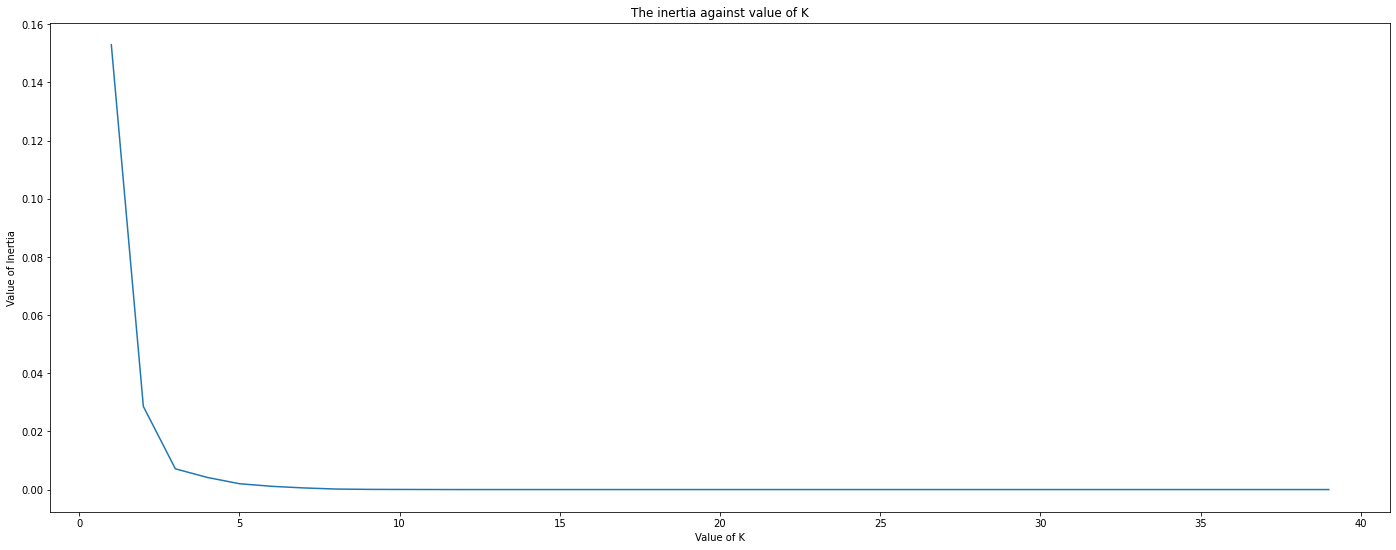

In [22]:
plt.figure(figsize=[24,9])

d = []
for k in range(1,40):
  kmean=KMeans(n_clusters=k)
  kmean.fit_predict(chires_df[['Chinese Restaurant']])
  d.append(kmean.inertia_)

plt.plot(range(1,40),d)
plt.xlabel("Value of K")
plt.ylabel('Value of Inertia')
plt.title("The inertia against value of K")
plt.show()

According to the result above, the optimal k value is 4, where there is an elbow point present.

2: Run K-means to cluster neighborhoods into 4 clusters.

In [23]:
kclusters = 4

chires_df_clustering = chires_df.drop('Neighborhood',axis=1)
kmeans = KMeans(n_clusters=kclusters, init='k-means++', random_state=0).fit(chires_df_clustering)

np.unique(kmeans.labels_)

array([0, 1, 2, 3], dtype=int32)

In [24]:
chires_clustering_result = chires_df.copy()
chires_clustering_result['Cluster Label'] = kmeans.labels_
chires_clustering_result['Cluster Label'].unique()

array([0, 3, 2, 1], dtype=int32)

3: Merge the result dataframe and toronto venues into one comprehensive dataframe.

In [25]:
chires_merged = chires_clustering_result.join(toronto_venues.set_index('Neighborhood'),on='Neighborhood')
chires_merged.sort_values(by='Chinese Restaurant',ascending=False,inplace=True)
chires_merged.head()

Neighborhood  Chinese Restaurant  \
3                                     Bayview Village                0.25   
3                                     Bayview Village                0.25   
3                                     Bayview Village                0.25   
3                                     Bayview Village                0.25   
23  Dorset Park, Wexford Heights, Scarborough Town...                0.20   

    Cluster Label  Neighborhood Latitude  Neighborhood Longitude  \
3               3              43.786947              -79.385975   
3               3              43.786947              -79.385975   
3               3              43.786947              -79.385975   
3               3              43.786947              -79.385975   
23              1              43.757410              -79.273304   

                            Venue  Venue Latitude  Venue Longitude  \
3   Sun Star Chinese Cuisine 翠景小炒       43.787914       -79.381234   
3                 TD Canada Trust       43.788074       -79.380367   
3     Maxim's Cafe and Patisserie       43.787863       -79.380751   
3                      Kaga Sushi       43.787758       -79.381090   
23                    Pho Vietnam       43.757770       -79.278572   

           Venue Category  
3      Chinese Restaurant  
3                    Bank  
3                    Café  
3     Japanese Restaurant  
23  Vietnamese Restaurant

4: Check the number of Chinese Restaurant in Toronto.

In [26]:
print("There are, in total, {} Chinese restaurant in Toronto".format(chires_merged['Venue Category'].value_counts()['Chinese Restaurant']))

There are, in total, 13 Chinese restaurant in Toronto


In [27]:
chires_merged.dropna(axis=0,inplace=True)

5: Visualize resulting clusters.

In [28]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chires_merged['Neighborhood Latitude'], chires_merged['Neighborhood Longitude'], chires_merged['Neighborhood'], chires_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat,lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Type II: Clustering with all venue categories.

1. Reapply elbow method to select best k value



In [29]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood',axis=1)
toronto_grouped_clustering.head()

Yoga Studio  Accessories Store  Adult Boutique  Airport  \
0          0.0                0.0             0.0      0.0   
1          0.0                0.0             0.0      0.0   
2          0.0                0.0             0.0      0.0   
3          0.0                0.0             0.0      0.0   
4          0.0                0.0             0.0      0.0   

   Airport Food Court  Airport Lounge  Airport Service  Airport Terminal  \
0                 0.0             0.0              0.0               0.0   
1                 0.0             0.0              0.0               0.0   
2                 0.0             0.0              0.0               0.0   
3                 0.0             0.0              0.0               0.0   
4                 0.0             0.0              0.0               0.0   

   American Restaurant  Antique Shop  Aquarium  Art Gallery  Art Museum  \
0             0.000000           0.0       0.0          0.0         0.0   
1             0.000000           0.0       0.0          0.0         0.0   
2             0.000000           0.0       0.0          0.0         0.0   
3             0.000000           0.0       0.0          0.0         0.0   
4             0.038462           0.0       0.0          0.0         0.0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                  0.0               0.0                 0.0          0.0   
1                  0.0               0.0                 0.0          0.0   
2                  0.0               0.0                 0.0          0.0   
3                  0.0               0.0                 0.0          0.0   
4                  0.0               0.0                 0.0          0.0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery      Bank  Bar  \
0            0.0        0.0         0.0         0.0     0.0  0.000000  0.0   
1            0.0        0.0         0.0         0.0     0.0  0.000000  0.0   
2            0.0        0.0         0.0         0.0     0.0  0.086957  0.0   
3            0.0        0.0         0.0         0.0     0.0  0.250000  0.0   
4            0.0        0.0         0.0         0.0     0.0  0.000000  0.0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0             0.0               0.0               0.0                 0.0   
1             0.0               0.0               0.0                 0.0   
2             0.0               0.0               0.0                 0.0   
3             0.0               0.0               0.0                 0.0   
4             0.0               0.0               0.0                 0.0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
0    0.0              0.0       0.0         0.0                 0.0   
1    0.0              0.0       0.0         0.0                 0.0   
2    0.0              0.0       0.0         0.0                 0.0   
3    0.0              0.0       0.0         0.0                 0.0   
4    0.0              0.0       0.0         0.0                 0.0   

   Bike Shop  Bistro  Boat or Ferry  Bookstore  Boutique  \
0        0.0     0.0            0.0        0.0       0.0   
1        0.0     0.0            0.0        0.0       0.0   
2        0.0     0.0            0.0        0.0       0.0   
3        0.0     0.0            0.0        0.0       0.0   
4        0.0     0.0            0.0        0.0       0.0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                   0.0        0.200000      0.0     0.000000   
1                   0.0        0.000000      0.0     0.000000   
2                   0.0        0.000000      0.0     0.043478   
3                   0.0        0.000000      0.0     0.000000   
4                   0.0        0.038462      0.0     0.000000   

   Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0              0.0       0.0           0.0            0.0       0.0   
1     

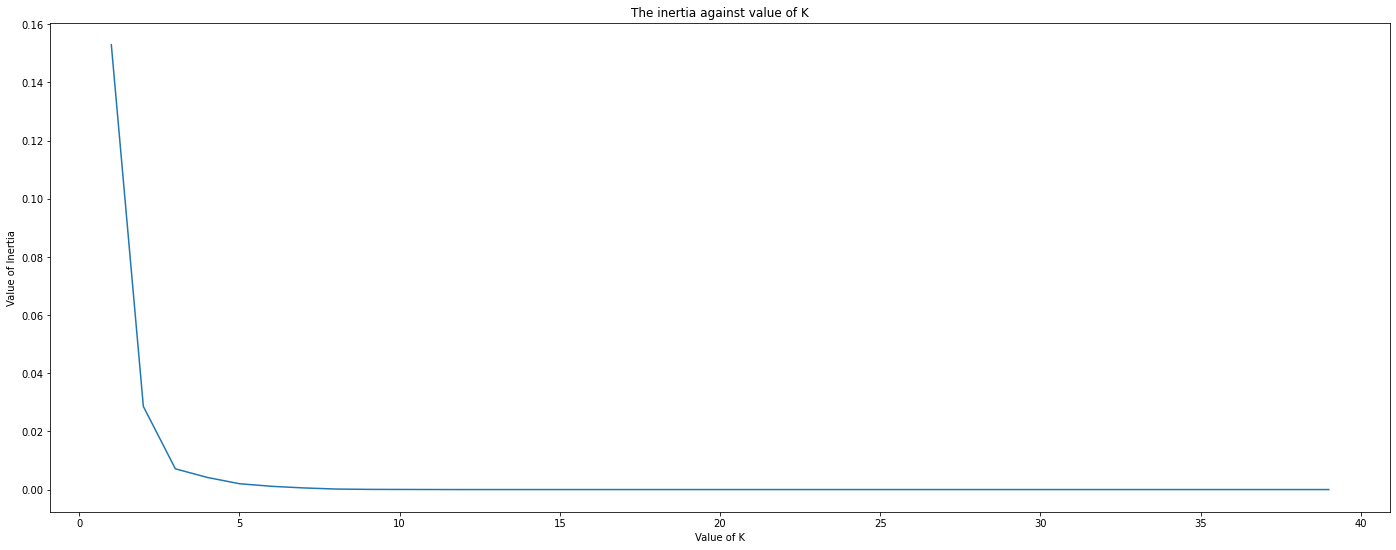

In [30]:
plt.figure(figsize=[24,9])

d2 = []
for k in range(1,40):
  kmean2=KMeans(n_clusters=k)
  kmean2.fit_predict(toronto_grouped_clustering)
  d2.append(kmean2.inertia_)

plt.plot(range(1,40),d)
plt.xlabel("Value of K")
plt.ylabel('Value of Inertia')
plt.title("The inertia against value of K")
plt.show()

According to the result above, the optimal k value is 4, where there is an elbow point present.

2: Run K-means to cluster neighborhoods into 4 clusters.

In [31]:
kclusters2 = 4

kmeans2 = KMeans(n_clusters=kclusters, init='k-means++', random_state=0).fit(toronto_grouped_clustering)

np.unique(kmeans2.labels_)

array([0, 1, 2, 3], dtype=int32)

In [32]:
toronto_grouped_clustering_result = toronto_grouped.copy()
toronto_grouped_clustering_result.dropna(axis=0,inplace=True)
toronto_grouped_clustering_result['Cluster Label'] = kmeans2.labels_
toronto_grouped_clustering_result['Cluster Label'].unique()

array([0, 2, 1, 3], dtype=int32)

Move the column Lable Cluster to the front for ease of reading.

In [33]:
toronto_grouped_clustering_result = toronto_grouped_clustering_result[ ['Cluster Label'] + [ col for col in toronto_grouped_clustering_result.columns if col != 'Cluster Label' ] ]
toronto_grouped_clustering_result = toronto_grouped_clustering_result[['Cluster Label','Neighborhood','Chinese Restaurant']]
toronto_grouped_clustering_result.head()

Cluster Label                                     Neighborhood  \
0              0                                        Agincourt   
1              0                           Alderwood, Long Branch   
2              0  Bathurst Manor, Wilson Heights, Downsview North   
3              0                                  Bayview Village   
4              0                Bedford Park, Lawrence Manor East   

   Chinese Restaurant  
0                0.00  
1                0.00  
2                0.00  
3                0.25  
4                0.00

3: Merge the result dataframe and geospatial info into one comprehensive dataframe

In [34]:
toronto_grouped_clustering_merged = toronto_grouped_clustering_result.join(toronto_venues.set_index('Neighborhood'),on='Neighborhood')
toronto_grouped_clustering_merged.sort_values(by='Cluster Label',ascending=False,inplace=True)
toronto_grouped_clustering_merged.head()

Cluster Label             Neighborhood  Chinese Restaurant  \
99              3          York Mills West                 0.0   
96              3  Willowdale, Newtonbrook                 0.0   
83              3       The Danforth  East                 0.0   
83              3       The Danforth  East                 0.0   
83              3       The Danforth  East                 0.0   

    Neighborhood Latitude  Neighborhood Longitude                Venue  \
99              43.752758              -79.400049      Tournament Park   
96              43.789053              -79.408493       Wedgewood park   
83              43.685347              -79.338106             The Path   
83              43.685347              -79.338106     Danforth & Jones   
83              43.685347              -79.338106  Donlands & Mortimer   

    Venue Latitude  Venue Longitude Venue Category  
99       43.751257       -79.399717           Park  
96       43.790635       -79.405494           Park  
83       43.683923       -79.335007           Park  
83       43.684352       -79.334792   Intersection  
83       43.687680       -79.340100   Intersection

4: Visualizing the resulting clusters.

In [35]:
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters2)
ys = [i + x + (i*x)**2 for i in range(kclusters2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_grouped_clustering_merged['Neighborhood Latitude'], toronto_grouped_clustering_merged['Neighborhood Longitude'], toronto_grouped_clustering_merged['Neighborhood'], toronto_grouped_clustering_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat,lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)

map_clusters2

We now can confirm that two types of clustering yeilded different results.

## Part5: Examine clusters


## Type I: Examine clusters in type I classification.

1: First, let's check how many neighborhoods in each cluster

In [36]:
num_of_neigh = chires_clustering_result['Cluster Label'].value_counts().to_frame()
num_of_neigh.reset_index(level=0,inplace=True)
num_of_neigh.columns=['Cluster Label','Number of Neighborhoods']
num_of_neigh.sort_values(by=['Cluster Label'],ascending=True,inplace=True)
num_of_neigh.reset_index(inplace=True)
num_of_neigh.drop('index',axis=1,inplace=True)
num_of_neigh

Cluster Label  Number of Neighborhoods
0              0                       92
1              1                        2
2              2                        5
3              3                        1

2: Present the results in a bar graph.

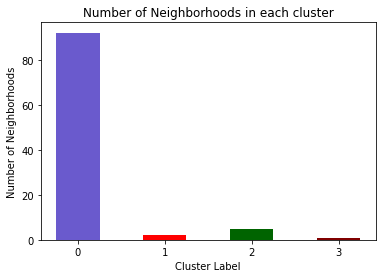

In [37]:
plt.bar(num_of_neigh['Cluster Label'],num_of_neigh['Number of Neighborhoods'],width=0.5,align='center',color=['slateblue','red','darkgreen','maroon'])
plt.xticks(ticks=[0,1,2,3],labels=num_of_neigh['Cluster Label'])
plt.xlabel('Cluster Label')
plt.ylabel('Number of Neighborhoods')
plt.title('Number of Neighborhoods in each cluster')
plt.show()

3: Then, check how many Chinese restaurant in each cluster.

In [38]:
num_of_chires = chires_clustering_result.groupby(by=['Cluster Label']).mean()['Chinese Restaurant'].to_frame()
num_of_chires.reset_index(level=0,inplace=True)
num_of_chires

Cluster Label  Chinese Restaurant
0              0            0.000746
1              1            0.183333
2              2            0.078182
3              3            0.250000

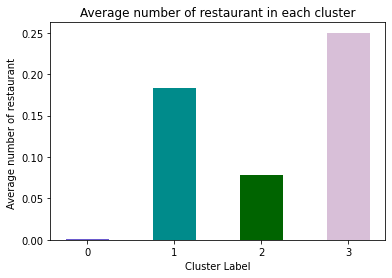

In [39]:
# sns.barplot(x='Cluster Label',
#             y='Chinese Restaurant',
#             hue=num_of_chires['Cluster Label'],
#             data=num_of_chires)
plt.bar(num_of_chires['Cluster Label'],num_of_chires['Chinese Restaurant'],width=0.5,align='center',color=['slateblue','darkcyan','darkgreen','thistle'])
plt.xticks(ticks=[0,1,2,3],labels=num_of_chires['Cluster Label'])
plt.xlabel('Cluster Label')
plt.ylabel('Average number of restaurant ')
plt.title('Average number of restaurant in each cluster')
plt.show()

Based on the resulted graph, we can observe that the cluster 3 (cluster label 2) has the highest average number of Chinese restaurants.

4: Let's check the number of Chinese restaurants against number of neighborhoods in each cluster.

In [40]:
chires_info = toronto_venues.loc[toronto_venues['Venue Category']=='Chinese Restaurant']
chires_info = chires_info[['Neighborhood','Venue']]
chires_info = chires_info.join(chires_clustering_result.set_index('Neighborhood'),on='Neighborhood')
chires_info.drop(labels=['Chinese Restaurant'],axis=1,inplace=True)
chires_info.sort_values(by='Cluster Label',ascending=True,inplace=True)
chires_info

Neighborhood  \
190                            Garden District, Ryerson   
763                        Fairview, Henry Farm, Oriole   
801   Harbourfront East, Union Station, Toronto Islands   
1074           Toronto Dominion Centre, Design Exchange   
1906                        St. James Town, Cabbagetown   
928         Kennedy Park, Ionview, East Birchmount Park   
1370  Dorset Park, Wexford Heights, Scarborough Town...   
237                                     Don Mills South   
1416                                          Westmount   
1444                                 North Toronto West   
1617            Clarks Corners, Tam O'Shanter, Sullivan   
1748                      Steeles West, L'Amoreaux West   
931                                     Bayview Village   

                                   Venue  Cluster Label  
190               GB Hand-Pulled Noodles              0  
763                           Manchu Wok              0  
801                   Pearl Harbourfront              0  
1074                    Szechuan Express              0  
1906                       China Gourmet              0  
928                           Hakka No.1              1  
1370                  Kim Kim restaurant              1  
237                     Congee Star 帝王名粥              2  
1416              Mayflower Chinese Food              2  
1444                           C'est Bon              2  
1617  The Royal Chinese Restaurant 避風塘小炒              2  
1748       Mr Congee Chinese Cuisine 龍粥記              2  
931        Sun Star Chinese Cuisine 翠景小炒              3

In [41]:
chires_count = chires_info.groupby(['Cluster Label']).count()
chires_count.reset_index(level=0,inplace=True)
chires_count = pd.concat([chires_count,num_of_neigh],axis=1)
chires_count = chires_count.loc[:,~chires_count.columns.duplicated()]
chires_count.drop(['Neighborhood'],axis=1,inplace=True)
chires_count.columns=['Cluster Label','Number of Chinese Restaurant','Number of neighborhoods in cluster']
chires_count['Num of restaurant per neighborhood'] = chires_count['Number of Chinese Restaurant']/chires_count['Number of neighborhoods in cluster']
chires_count

Cluster Label  Number of Chinese Restaurant  \
0              0                             5   
1              1                             2   
2              2                             5   
3              3                             1   

   Number of neighborhoods in cluster  Num of restaurant per neighborhood  
0                                  92                            0.054348  
1                                   2                            1.000000  
2                                   5                            1.000000  
3                                   1                            1.000000

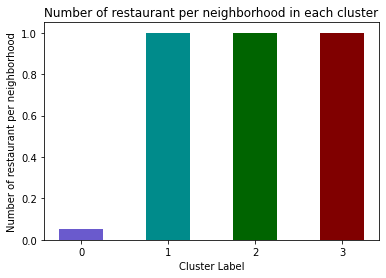

In [42]:
plt.bar(chires_count['Cluster Label'],chires_count['Num of restaurant per neighborhood'],width=0.5,align='center',color=['slateblue','darkcyan','darkgreen','maroon'])
plt.xticks(ticks=[0,1,2,3],labels=chires_count['Cluster Label'])
plt.xlabel('Cluster Label')
plt.ylabel('Number of restaurant per neighborhood')
plt.title('Number of restaurant per neighborhood in each cluster')
plt.show()

## Type II: Examine clusters in Type II classification.

1: First, let's check how many neighborhoods in each cluster

In [43]:
num_of_neigh2 = toronto_grouped_clustering_result['Cluster Label'].value_counts().to_frame()
num_of_neigh2.reset_index(level=0,inplace=True)
num_of_neigh2.columns=['Cluster Label','Number of Neighborhoods']
num_of_neigh2.sort_values(by=['Cluster Label'],ascending=True,inplace=True)
num_of_neigh2.reset_index(level=0,inplace=True)
num_of_neigh2.drop('index',axis=1,inplace=True)
num_of_neigh2

Cluster Label  Number of Neighborhoods
0              0                       84
1              1                        2
2              2                       10
3              3                        4

2: Present the results in a bar graph.

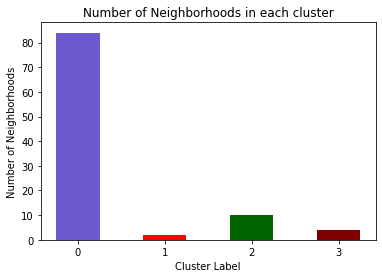

In [44]:
plt.bar(num_of_neigh2['Cluster Label'],num_of_neigh2['Number of Neighborhoods'],width=0.5,align='center',color=['slateblue','red','darkgreen','maroon'])
plt.xticks(ticks=[0,1,2,3],labels=num_of_neigh2['Cluster Label'])
plt.xlabel('Cluster Label')
plt.ylabel('Number of Neighborhoods')
plt.title('Number of Neighborhoods in each cluster')
plt.show()

3: Then, check how many Chinese restaurant in each cluster.

In [45]:
num_of_chires2 = toronto_grouped_clustering_result.groupby(by=['Cluster Label']).mean()['Chinese Restaurant'].to_frame()
num_of_chires2.reset_index(level=0,inplace=True)
num_of_chires2

Cluster Label  Chinese Restaurant
0              0            0.012812
1              1            0.000000
2              2            0.000000
3              3            0.000000

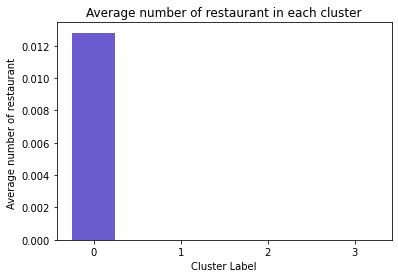

In [46]:
plt.bar(num_of_chires2['Cluster Label'],num_of_chires2['Chinese Restaurant'],width=0.5,align='center',color=['slateblue','darkcyan','darkgreen','thistle'])
plt.xticks(ticks=[0,1,2,3],labels=num_of_chires2['Cluster Label'])
plt.xlabel('Cluster Label')
plt.ylabel('Average number of restaurant ')
plt.title('Average number of restaurant in each cluster')
plt.show()

Based on the resulted graph, we can observe that the cluster 2 (cluster label 1) has the highest average number of Chinese restaurants. Cluster 1 (cluster label 0) and cluster 4 (cluster label 3) do not have chinese restaurant available for consumers.

4: Let's check the number of Chinese restaurants against number of neighborhoods in each cluster.

In [47]:
chires_info2 = toronto_venues.loc[toronto_venues['Venue Category']=='Chinese Restaurant']
chires_info2 = chires_info2[['Neighborhood','Venue']]
chires_info2 = chires_info2.join(toronto_grouped_clustering_result.set_index('Neighborhood'),on='Neighborhood')
chires_info2.drop(labels=['Chinese Restaurant'],axis=1,inplace=True)
chires_info2.sort_values(by='Cluster Label',ascending=True,inplace=True)
chires_info2

Neighborhood  \
190                            Garden District, Ryerson   
237                                     Don Mills South   
763                        Fairview, Henry Farm, Oriole   
801   Harbourfront East, Union Station, Toronto Islands   
928         Kennedy Park, Ionview, East Birchmount Park   
931                                     Bayview Village   
1074           Toronto Dominion Centre, Design Exchange   
1370  Dorset Park, Wexford Heights, Scarborough Town...   
1416                                          Westmount   
1444                                 North Toronto West   
1617            Clarks Corners, Tam O'Shanter, Sullivan   
1748                      Steeles West, L'Amoreaux West   
1906                        St. James Town, Cabbagetown   

                                   Venue  Cluster Label  
190               GB Hand-Pulled Noodles              0  
237                     Congee Star 帝王名粥              0  
763                           Manchu Wok              0  
801                   Pearl Harbourfront              0  
928                           Hakka No.1              0  
931        Sun Star Chinese Cuisine 翠景小炒              0  
1074                    Szechuan Express              0  
1370                  Kim Kim restaurant              0  
1416              Mayflower Chinese Food              0  
1444                           C'est Bon              0  
1617  The Royal Chinese Restaurant 避風塘小炒              0  
1748       Mr Congee Chinese Cuisine 龍粥記              0  
1906                       China Gourmet              0

In [48]:
chires_count2 = chires_info2.groupby(['Cluster Label']).count()
chires_count2 = pd.concat([chires_count2,num_of_neigh2],axis=1)
chires_count2.drop(['Neighborhood'],axis=1,inplace=True)
chires_count2.columns=['Number of Chinese Restaurant','Cluster Label','Number of neighborhoods in cluster']
chires_count2 = chires_count2[['Cluster Label'] + [col for col in chires_count2 if col != 'Cluster Label']]
chires_count2['Num of restaurant per neighborhood'] = chires_count2['Number of Chinese Restaurant']/chires_count2['Number of neighborhoods in cluster']
chires_count2.replace(np.nan,0,inplace=True)
chires_count2

Cluster Label  Number of Chinese Restaurant  \
0              0                          13.0   
1              1                           0.0   
2              2                           0.0   
3              3                           0.0   

   Number of neighborhoods in cluster  Num of restaurant per neighborhood  
0                                  84                            0.154762  
1                                   2                            0.000000  
2                                  10                            0.000000  
3                                   4                            0.000000

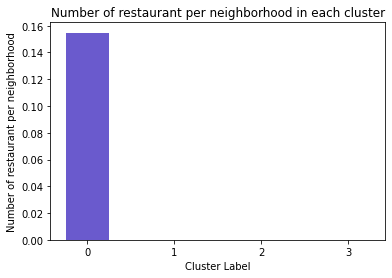

In [49]:
plt.bar(chires_count2['Cluster Label'],chires_count2['Num of restaurant per neighborhood'],width=0.5,align='center',color=['slateblue','darkcyan','darkgreen','maroon'])
plt.xticks(ticks=[0,1,2,3],labels=chires_count2['Cluster Label'])
plt.xlabel('Cluster Label')
plt.ylabel('Number of restaurant per neighborhood')
plt.title('Number of restaurant per neighborhood in each cluster')
plt.show()

5: Now let's check number of venues in total in each cluster.

In [50]:
num_of_venue = toronto_grouped_clustering_merged.groupby(by=['Cluster Label']).count()
num_of_venue = num_of_venue[['Venue']]
num_of_venue.columns=['Venue count']
num_of_venue.reset_index(level=0,inplace=True)
num_of_venue.head()

Cluster Label  Venue count
0              0         2083
1              1            2
2              2           34
3              3            9

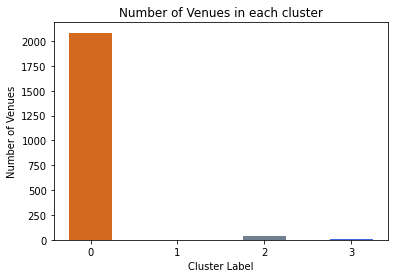

In [51]:
plt.bar(num_of_venue['Cluster Label'],num_of_venue['Venue count'],width=0.5,align='center',color=['chocolate','tomato','slategray','royalblue'])
plt.xticks(ticks=[0,1,2,3],labels=num_of_venue['Cluster Label'])
plt.xlabel('Cluster Label')
plt.ylabel('Number of Venues')
plt.title('Number of Venues in each cluster')
plt.show()

6. List the neighborhoods in cluster 1, 3 and 4.

In [52]:
no_chires_neigh = toronto_grouped_clustering_merged.loc[toronto_grouped_clustering_merged['Cluster Label']!=1]
neigh_list = no_chires_neigh['Neighborhood'].unique().tolist()
for name in neigh_list:
  print(name)

York Mills West
Willowdale, Newtonbrook
The Danforth  East
Weston
Downsview West
Lawrence Park
Caledonia-Fairbanks
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Downsview East
Parkwoods
The Kingsway, Montgomery Road, Old Mill North
North Park, Maple Leaf Park, Upwood Park
Forest Hill North & West
Rosedale
Parkdale, Roncesvalles
Parkview Hill, Woodbine Gardens
Ontario Provincial Government
Regent Park, Harbourfront
North Toronto West
Northwood Park, York University
New Toronto, Mimico South, Humber Bay Shores
Richmond, Adelaide, King
Runnymede, Swansea
Rouge Hill, Port Union, Highland Creek
Roselawn
Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West
India Bazaar, The Beaches West
Kensington Market, Chinatown, Grange Park
Kennedy Park, Ionview, East Birchmount Park
High Park, The Junction South
Harbourfront East, Union Station, Toronto Islands
Humewood-Cedarvale
Humber Summit
Hillcrest Village
Little Portugal, Trinity
Moore Park, Sum

## Discussion and conclusion:

### Type I clustering (Chinese restaurant only):


This type of clustering merely consider the competition between businesses/venues of the same category, which is Chinese restaurant. The results indicate that cluster 1 (cluster label 0) has the most number of neighborhoods, 92, but the least number of restaurant on average among all venues and the least number of restaurant per neighborhood. Cluster 2,3 and 4 have similar number of Chinese restaurant per neighborhood, respetively, 1.0,1.2 and 1.0. Specifically, cluster 3 has the highest number of restaurant on average among all venues. 

In conclusion, combining with the visualization on map, it is recommended for a new Chinese restaurant to open up in the area between Etobicoke and York, and North York because there is fewer number of Chinese restaurant hence less competition from the same type of venues. Eastern area around Scarborough and East York would also be a good option for the new business. 

The advantage for this type of anlaysis is that eliminating noise from other type of venues and focus on Chinese restaurant. However, the drawback would be the same. Operating a business is supposed to include all noises and consider as many circunstances as possible to make optimal buiness decisions. There are hundreds types of restaurants and venues available for citizens in Toronto and they all are interfering with each other. For example, cluster 3 (label 2) seems a bad option for Chinese restaurant due to high competition from the same type of business. However, these neighborhoods may have limited venues/restaurants compared to other clusters and Chinese restaurant might therefore become noticable for citizens in these areas and consequently become popular in neighborhoods, which conflits the original conclusion.
All in all, this type of clustering is unilateral and lack of foresight for businesses in long run. It should be a one of references while making optimal business operation decisions.

### Type II clustering (all venues included)

In Type II clustering, cluster 1 (cluster label 0), cluster 3 (cluster label 2) and cluster 4 (cluster label 3) do not have any Chinese restaurant available for citizens. Cluster 2 (cluster label 1) has, on average, 0.01 Chinese restaurant by the results of onehot coding and 0.15 Chinese restaurant per neighborhood. Moreover, cluster 2 has 2125 venues, which is significantly more than the rest of clusters. As a consequence, cluster 2 should be excluded for the new Chinese restaurant as the competition between businesses has already been intensive. In addition, cluster 1, cluster 3 and cluster 4 have 6, 3 and 1 neighborhood and these neighborhoods should be on the top of the consideration because they have much fewer venues, thus, industrial competition. These neighborhoods are listed as following:

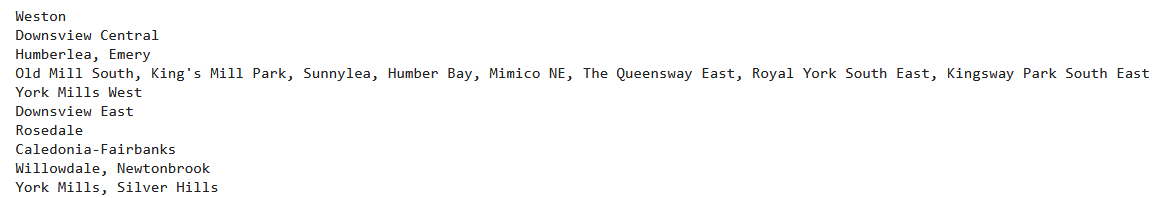

The advantage for this type of clustering, as mentioned, is that it includes noises from other business, no matter what types they are. By doing so, business owner will be able to make the comprehensive and forward-looking decisions regarding potential location and operation strategies as neighborhoods differ in scale and demographics.

## Future expectation

The analysis in this project needs more foundational information in the future such as neighborhood population size and data related to citizen consumptions, for instance, apartment rental price that could reflect how vibrant a neighborhood could be. To find out the best location for a new business is not easy. Specifically, business owners should give priority to characteristics of neighborhoods while making the decision, for example, opening up a Indian restaurant in a Korean town may not seem a good decision for the best profit.

Importance of Delivery during COVID:


> The next step would be collecting more data on neighborhood and venues. One of the important direction is to collect delivery data during COVID-19. Food delivery is becoming a popular trend in the metropolitans like Toronto. Delivery may account for majority of the business in the near future since COVID-19 could last for few years. Therefore, considering how delivery has performed in restaurants is vital. It could change the balance between each element, for example, delivery may undermine the importance of neighborhood population size, but value more on rental price of the facilities.

